# HYPER PARAMS

In [1]:
plot2d = False
plot3d = False
train = False
boxplotting = True

# Imports and data processing

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import gaussian_kde
from matplotlib.dates import date2num, num2date
from pandas.api.types import CategoricalDtype

from prophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot') 
plt.style.use('fivethirtyeight')

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

/Users/marcusnsr/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [3]:
# Import data from excel file
df = pd.read_excel('COURT_BOOKINGS2.xlsx')
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.drop(['Skalar'], axis=1)

In [ ]:
# Get only the columns we need
df2 = df[['Datetime', 'y']]
df2 = df2.rename(columns={'Datetime': 'ds', 'y': 'y'})

# Plots )noprophet

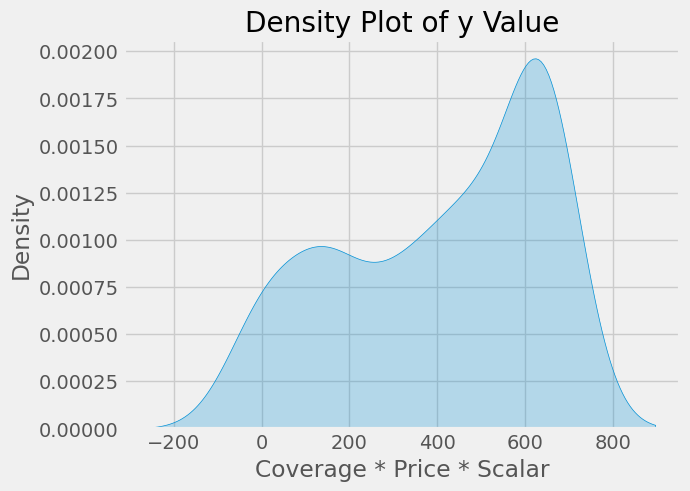

In [5]:
if plot2d:
    # Create a dencity plot of the data to see the distribution
    # Assuming your DataFrame is named df
    sns.kdeplot(df['y'], shade=True)
    plt.title('Density Plot of y Value')
    plt.xlabel('Coverage * Price * Scalar')
    plt.ylabel('Density')
    plt.show()


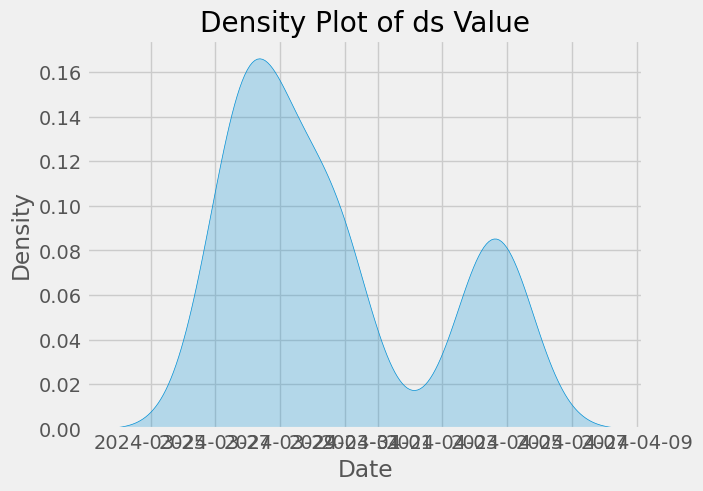

In [6]:
if plot2d:
    # Plot dencity plot with datatime on x-axis
    sns.kdeplot(df['Datetime'], shade=True)
    plt.title('Density Plot of ds Value')
    plt.xlabel('Date')
    plt.ylabel('Density')
    plt.show()

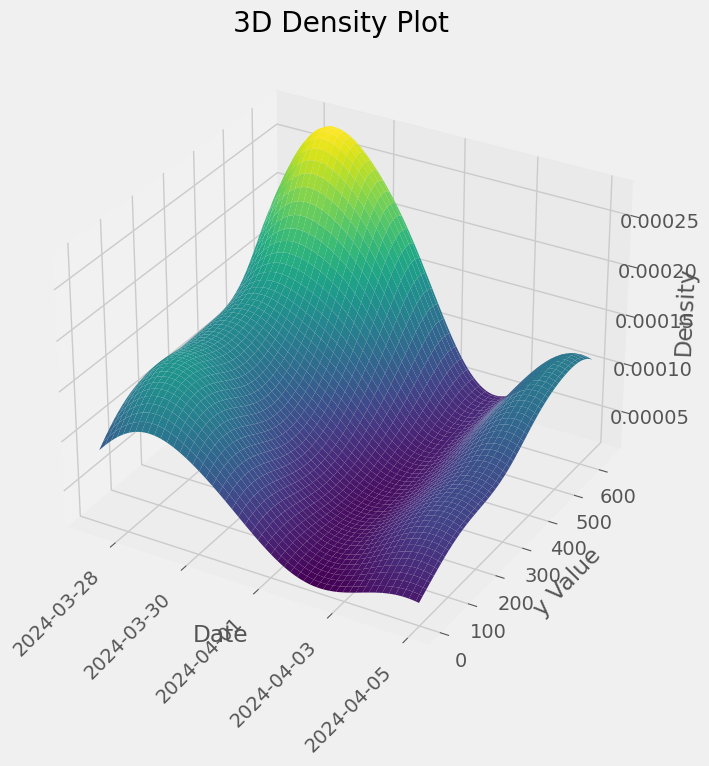

In [7]:
if plot3d:
    # Convert 'Datetime' to a numerical format for KDE calculation
    datetime_numeric = date2num(df['Datetime'])

    # Calculate the points for the KDE
    x = datetime_numeric
    y = df['y'].values
    values = np.vstack([x, y])
    kernel = gaussian_kde(values)

    # Create a grid over which the KDE will be evaluated
    xmin, xmax = min(x), max(x)
    ymin, ymax = min(y), max(y)
    X, Y = np.meshgrid(np.linspace(xmin, xmax, 100), np.linspace(ymin, ymax, 100))
    positions = np.vstack([X.ravel(), Y.ravel()])
    Z = np.reshape(kernel(positions).T, X.shape)

    # Plotting the 3D KDE
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='viridis')

    # Setting labels and title
    ax.set_xlabel('Date')
    ax.set_ylabel('y Value')
    ax.set_zlabel('Density')
    ax.set_title('3D Density Plot')

    # Formatting the X-axis to show dates
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: num2date(val).strftime('%Y-%m-%d')))
    for label in ax.get_xticklabels(which='major'):
        label.set_rotation(45)
        label.set_horizontalalignment('right')

    plt.show()

# Prophet forecasting

12:16:48 - cmdstanpy - INFO - Chain [1] start processing


12:16:48 - cmdstanpy - INFO - Chain [1] done processing


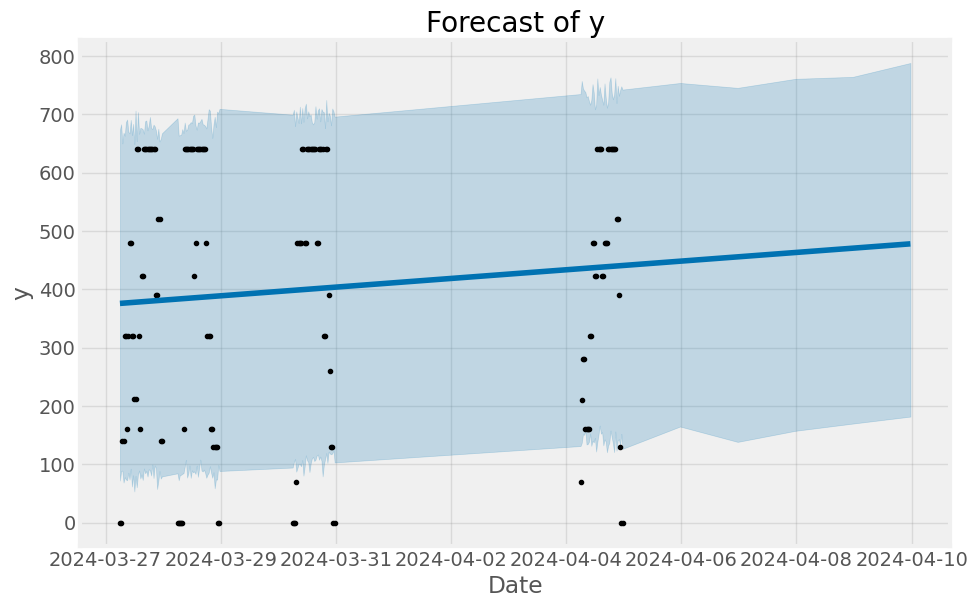

In [10]:
if train:
    # Initialize the Prophet model
    model = Prophet(daily_seasonality=False, yearly_seasonality=False)

    # Fit the model with the preprocessed data
    model.fit(df2)

    # Create a dataframe for future predictions covering the next 30 days
    future_dates = model.make_future_dataframe(periods=5)

    # Make predictions
    forecast = model.predict(future_dates)

    # Plot the forecast
    model.plot(forecast)
    plt.title('Forecast of y')
    plt.xlabel('Date')
    plt.ylabel('y')
    plt.show()

# boxplot weekdays

In [15]:
if boxplotting:
    cat_type = CategoricalDtype(categories=['Monday','Tuesday',
                                            'Wednesday',
                                            'Thursday','Friday',
                                            'Saturday','Sunday'],
                                ordered=True)

    def create_features(df, label=None):
        """
        Creates time series features from datetime index.
        """
        df = df.copy()
        df['hour'] = df['ds'].dt.hour
        df['dayofweek'] = df['ds'].dt.dayofweek
        df['weekday'] = df['ds'].dt.day_name()
        df['weekday'] = df['weekday'].astype(cat_type)
        df['quarter'] = df['ds'].dt.quarter
        df['month'] = df['ds'].dt.month
        df['year'] = df['ds'].dt.year
        df['dayofyear'] = df['ds'].dt.dayofyear
        df['dayofmonth'] = df['ds'].dt.day
        df['date_offset'] = (df.ds.dt.month*100 + df.ds.dt.day - 320)%1300

        df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], 
                            labels=['Spring', 'Summer', 'Fall', 'Winter']
                    )
        X = df[['hour','dayofweek','quarter','month','year',
            'dayofyear','dayofmonth','weekday',
            'season']]
        if label:
            y = df[label]
            return X, y
        return X

    X, y = create_features(df2, label='y')
    features_and_target = pd.concat([X, y], axis=1)

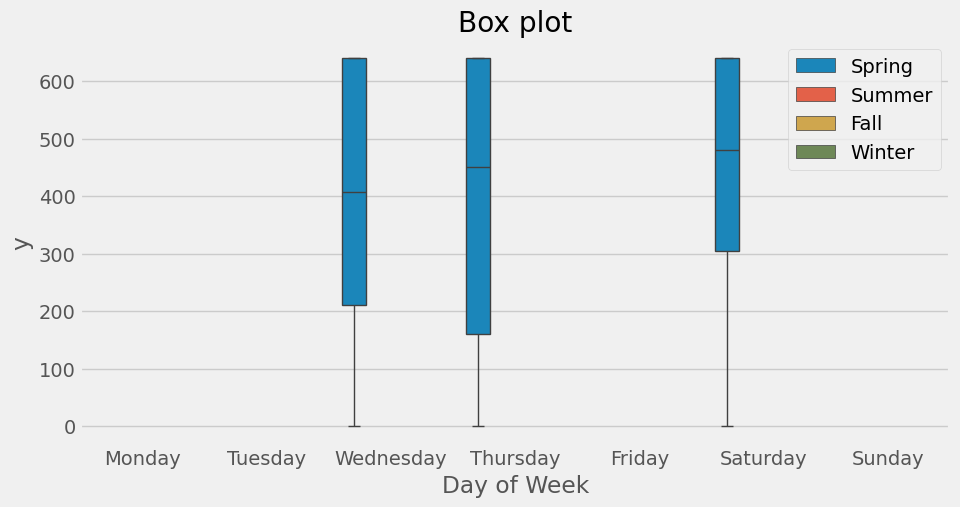

In [17]:
if boxplotting:  
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.boxplot(data=features_and_target.dropna(),
                x='weekday',
                y='y',
                hue='season',
                ax=ax,
                linewidth=1)
    ax.set_title('Box plot')
    ax.set_xlabel('Day of Week')
    ax.set_ylabel('y')
    ax.legend(bbox_to_anchor=(1, 1))
    plt.show()